# App Development
This section aims to develop an interactive data application that retrieves patient records from Google Drive, processes them, and generates an interactive visualization. The visualization compares past similar situations with the input data and provides suggestions for the short-acting insulin dose (shID) and predicts the resulting post-meal glucose level (BG2).

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestRegressor
import panel as pn

### Prepare data
#### Read data

In [2]:
# Read data from Google Drive
url='https://docs.google.com/spreadsheets/d/1Kvv9SnmlRGG3tZP-54D29kwOtsCWa6eZ7zk_iBwFdl4/edit?usp=sharing'
path = 'https://docs.google.com/spreadsheets/d/'+url.split('/')[-2]+'/export?gid=0&format=csv'
main_df = pd.read_csv(path).drop(['Date','pshID/pBG2'],axis=1)

#### Separate the input_row and the rest of the data

In [3]:
# Train set - filtered data (BG2 within normal range), all rows excluding the last one
train_data = main_df[(main_df['BG2']>3.9) & (main_df['BG2']<5.5)].iloc[:-1].reset_index(drop=True)
# Test set - the last row
test_data = main_df.iloc[[-1]]

### Functions for the app

In [4]:
# Scale using MinMaxScaler
def scale(df):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df.values)
    return pd.DataFrame(scaled_data, columns=df.columns)

In [5]:
# Find indices of 4 rows that are similar to the input row
def find_similar_rows(df):
    df_wd = pd.get_dummies(df)
    similarity_scores = cosine_similarity(df_wd.iloc[:-1], df_wd.iloc[[-1]]).flatten()
    sorted_indices = np.argsort(similarity_scores)[::-1]
    df_sorted = df.iloc[sorted_indices]
    return df_sorted.index[df_sorted['Interval']==df.iloc[-1,0]][:4]

In [6]:
# Train RandomForestRegressor and predict target label
def predict(X_train,X_test,y):
    
    model = RandomForestRegressor()
    model.fit(X_train,y)
    
    return model.predict(X_test)   

### Style configuration

In [15]:
#Colors
background = '#F0F0F0'
red = '#ED462F'
pink = '#F1BBB8'
green = '#4CB866'
blue = '#003D83'
black = '#333333'
grey = '#C6D0D2'

#CSS 
css = '''
.bk-root {
    font-family: monospace 
}
.bk-root .bk-input {
    border-radius: 0px;
    border: none;
    box-shadow:none;
    background:#F0F0F0
}
.bk-root .noUi-target {
    border-radius: 0px; 
    box-shadow:none;
    border: none;
    background: #F0F0F0
}
.bk-root .noUi-connects {
    border-radius: 0px;
}
.bk-root .noUi-handle {
    box-shadow: none;
    border: 3px solid;
    border-color: black;
    background: #F0F0F0;
}
.bk-root .noUi-horizontal .noUi-handle {
    width: 10px;
    height: 10px;
    right: -5px;
    top: 0px;
    border-radius: 5px;
}
.bk-root .noUi-horizontal .noUi-tooltip {
    bottom: -38px;
}
.bk-root .noUi-tooltip {
    border: none;
    border-radius: 0px;
    background: black;
    color: white;
}
'''

#Matplotlib configurations

plt.rcParams.update({'axes.facecolor' : grey,
                     'axes.edgecolor': background,   
                     'axes.linewidth': 2,
                     'figure.facecolor' : background,
                     'font.family' : 'monospace',
                     'xtick.color' : background,
                     'ytick.color' : background,
                     'xtick.labelcolor' : '#8C9496',
                     'ytick.labelcolor' : '#8C9496',
                     'legend.labelcolor' : '#8C9496',
                     'axes.spines.top' : False,
                     'axes.spines.bottom' : False,
                     'axes.spines.right' : False
                     })


#Panel configuration
pn.extension(raw_css=[css])

### Widgets for the app

In [17]:
# Create widgets for the input data
widgets = {   
        'Interval' : pn.widgets.Select(name='Interval', options=['B-L', 'L-D', 'D-B'],
                                       value=test_data['Interval'].values[0]),
    
         **{column : pn.widgets.FloatSlider(name=column, 
                                            start=min(train_data[column]), 
                                            end=max(train_data[column]), 
                                            value=test_data[column].values[0],
                                            bar_color='#333333') for column in train_data.iloc[:,1:6].columns}
}

### Plotting function

In [18]:
def create_plot(**kwargs):
    # Define data
    ## Concatenate the data with the inputs from the widgets 
    widgets_row = pd.DataFrame(kwargs, index=[0])
    all_rows = pd.concat([train_data, widgets_row]).reset_index(drop=True)
    
    ## Find similar rows indices using ['Interval','DV','BG1','SC','Temp','Humid']
    similar_rows_indices = find_similar_rows(all_rows.iloc[:, :6])
    
    ## Define data for plotting
    plot_df = all_rows.iloc[:, 1:] # numeric columns only
    scaled_plot_df = scale(plot_df)
    cols = plot_df.columns
    
    # Predict shID class
    ## Define X_test using the last row of the scaled data frame
    X_test = scaled_plot_df.iloc[[-1], :5]
    
    ## Define X_train and y depending on the interval
    if widgets_row['Interval'].values[0] == 'B-L':
        indices_BL = train_data.index[train_data['Interval'] == 'B-L']
        X_train_shID = scaled_plot_df.iloc[indices_BL, :5]
        y_shID = scaled_plot_df.iloc[indices_BL, 5]
        X_train_BG2 = scaled_plot_df.iloc[indices_BL, :6]
        y_BG2 = scaled_plot_df.iloc[indices_BL, 6]
    elif widgets_row['Interval'].values[0] == 'L-D':
        indices_LD = train_data.index[train_data['Interval'] == 'L-D']
        X_train_shID = scaled_plot_df.iloc[indices_LD, :5]
        y_shID = scaled_plot_df.iloc[indices_LD, 5]
        X_train_BG2 = scaled_plot_df.iloc[indices_LD, :6]
        y_BG2 = scaled_plot_df.iloc[indices_LD, 6]
    else:
        indices_DB = train_data.index[train_data['Interval'] == 'D-B']
        X_train_shID = scaled_plot_df.iloc[indices_DB, :5]
        y_shID = scaled_plot_df.iloc[indices_DB, 5]
        X_train_BG2 = scaled_plot_df.iloc[indices_DB, :6]
        y_BG2 = scaled_plot_df.iloc[indices_DB, 6]
    
    ## Predict shID within a particular interval
    prediction_shID = predict(X_train_shID, X_test, y_shID)
    X_test['shID'] = prediction_shID
    prediction_BG2 = predict(X_train_BG2, X_test, y_BG2)
    
    ###########################################################
    
    # Plot
    ## Define figure and axes
    fig, axes = plt.subplots(figsize=(12, 6.5))
    
    ## Configure axes parameters
    axes.set_xlim(0, len(cols) - 1)
    axes.set_xticks(axes.get_xticks())
    axes.set_xticklabels(scaled_plot_df.columns)
    plt.tick_params(axis='x', which='both', pad=15)
    
    ## Create twin axes
    twin_axes = []
    for i in range(1, len(cols)):
        ax = plt.twinx()
        ax.spines["left"].set_position(("axes", i / (len(cols) - 1)))
        twin_axes.append(ax)
    
    ## A list of all axes
    all_axes = [axes] + twin_axes
    
    ## Plot the similar lines (scaled)
    colors = [red, blue, green, pink]
    for i in range(len(similar_rows_indices)):
        all_axes[-1].plot(range(0, len(cols)), scaled_plot_df.iloc[similar_rows_indices[i]], color=colors[i])
        
    ## Plot the input line (scaled)
    input_line = scaled_plot_df.iloc[-1]
    input_line[-2] = prediction_shID
    input_line[-1] = prediction_BG2
    all_axes[-1].plot(range(0, len(cols)), input_line, color='#333333', lw=4)
    
    ## Add inversed predicted values
    plot_df.iloc[-1,-2] = np.round(prediction_shID*(plot_df.iloc[:,-2].max()-plot_df.iloc[:,-2].min())+plot_df.iloc[:,-2].min(),1)
    plot_df.iloc[-1,-1] = np.round(prediction_BG2 *(plot_df.iloc[:,-1].max()-plot_df.iloc[:,-1].min())+plot_df.iloc[:,-1].min(),2)
    
    ## Annotate each point
    edgecolors = ['#333333','#333333','#333333','#333333','#333333',red,red]
    for i in range(0, len(cols)):

        text = f'{round(plot_df.iloc[-1,i],3)}'

        plt.annotate(text, (i, scaled_plot_df.iloc[-1,i]), 
                     xytext=(i, scaled_plot_df.iloc[-1,i]), 
                     color=background,fontweight='bold',
                     ha='center', va='center',
                     bbox=dict(boxstyle='circle', facecolor='#333333', 
                               edgecolor=edgecolors[i],linewidth=4,pad=0.6))

    
    ## Create new y tick labels
    custom_ytick_labels = []
    for c in cols:
        custom_ytick_labels.append(np.round(np.linspace(plot_df[c].min(), plot_df[c].max(), 9), 2))
        
    ## Assign ne y tick labels
    yticks = np.linspace(0, 1, 9)  
    for i, ax in enumerate(all_axes):
        ax.set_ylim(0, 1)
        ax.set_yticks(yticks)
        ax.set_yticklabels(custom_ytick_labels[i], va='bottom')
        
    ## Create legend
    patches = []
    a = 1
    for color in colors:
        patches.append(plt.Line2D([], [], color=color, label=f'situation {a}'))
        a += 1
    
    patches.append(plt.Rectangle((0,0), 1,1, facecolor='#333333', edgecolor='#333333', lw=4, label='input value'))
    patches.append(plt.Rectangle((0,0), 1,1, facecolor='#333333', edgecolor=red, lw=4, label='predicted value'))
    
    axes.legend(handles=patches, frameon=False, loc=(0.05,-0.2), ncol=6)

    
    ## Display
    plt.tight_layout()
    plt.close(fig)
    
    return pn.pane.Matplotlib(fig, sizing_mode='scale_both',margin=(5,25))


### Panel app

Row(background='#C6D0D2')
    [0] Column(margin=(0, 15))
        [0] Markdown(str)
        [1] Markdown(str)
        [2] Column
            [0] Select(name='Interval', options=['B-L', 'L-D', 'D-B'], value='D-B')
            [1] FloatSlider(bar_color='#333333', end=4.003, name='DV', start=0.804, value=2.643)
            [2] FloatSlider(bar_color='#333333', end=8.2, name='BG1', start=2.9, value=4.7)
            [3] FloatSlider(bar_color='#333333', end=6590, name='SC')
            [4] FloatSlider(bar_color='#333333', end=-5, name='Temp', start=-33, value=-9)
            [5] FloatSlider(bar_color='#333333', end=95, name='Humid', start=55, value=74)
    [1] Column(background='#F0F0F0', sizing_mode='scale_both')
        [0] Spacer(height=53)
        [1] Markdown(str)
        [2] Row(sizing_mode='scale_both')
            [0] Matplotlib(Figure, height=432, margin=(5, 25), sizing_mode='scale_both', width=864)
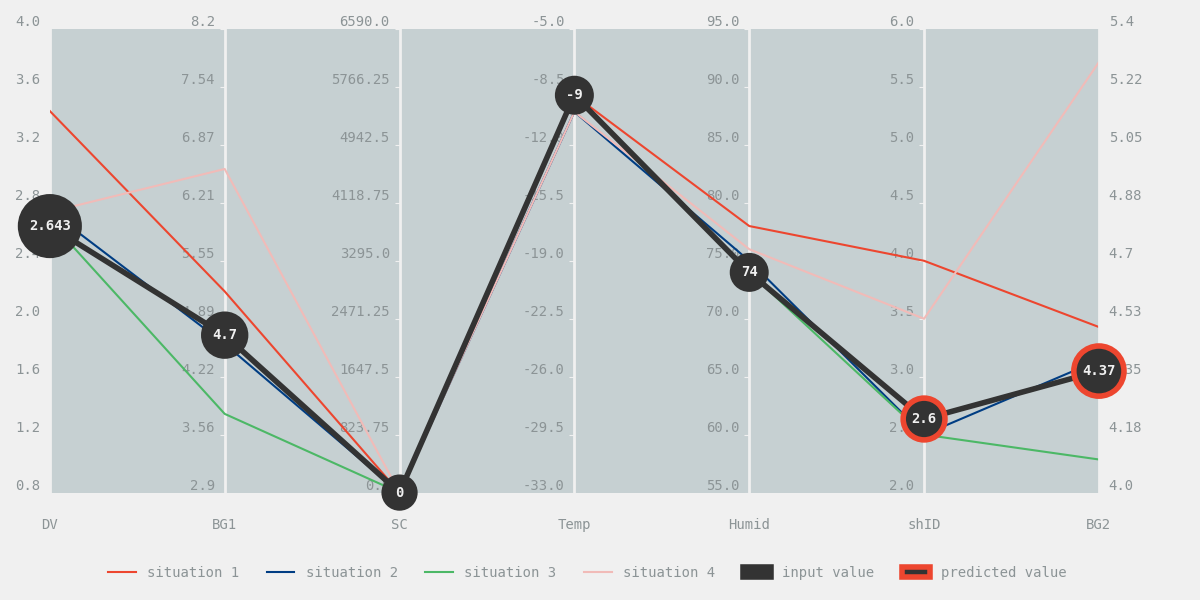

In [19]:
# Create layout elements by connecting the widgets and the plot function
layout = pn.interact(create_plot, **widgets)

# Create the dashborad's columns
widgets_column = pn.Column(pn.pane.Markdown('##**&nbsp;:: diabetes_app**'),
                           pn.pane.Markdown('###**&nbsp;_Input data**'),
                           layout[0],
                           margin=(0,15))
plot_column = pn.Column(pn.Spacer(height=53),
                        pn.pane.Markdown('###**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;_Visualisation of the most similar situations vs the input data**'),
                        layout[1],
                        sizing_mode='scale_both',background=background)

# Assemble the dashboard
dashboard = pn.Row(widgets_column,plot_column,background=grey)

# Serve the app
dashboard.servable()

## Results

Using of Holoviz Panel, an interactive app was successfully created for visualizing data and integrating interactive predictions. The app was deployed via MyBinder, enabling remote access to its functionalities.

## Conclusion

By utilizing the power of modern machine learning algorithms, Python-based visualization techniques, and cloud storage and deployment solutions, a valuable tool has been developed for an individual with Type 1 Diabetes. This tool has the potential to benefit a wider population of individuals affected by this condition. However, further research and analysis are necessary to fully realize this potential and expand the impact of the tool.